In [320]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [321]:
transactions_im = pd.read_csv('transactions_cluster4.csv', header=0)

In [322]:
transactions = transactions_im.fillna(0)

In [323]:
transactions['date'] = pd.to_datetime(transactions['date'], format = '%Y-%m-%d')
transactions = transactions.set_index('date')

In [324]:
ts = transactions.mean(axis=1)
ts.head()

date
2017-04-20    740.250000
2017-04-21    785.500000
2017-04-22    873.833333
2017-04-23    822.083333
2017-04-24    731.166667
dtype: float64

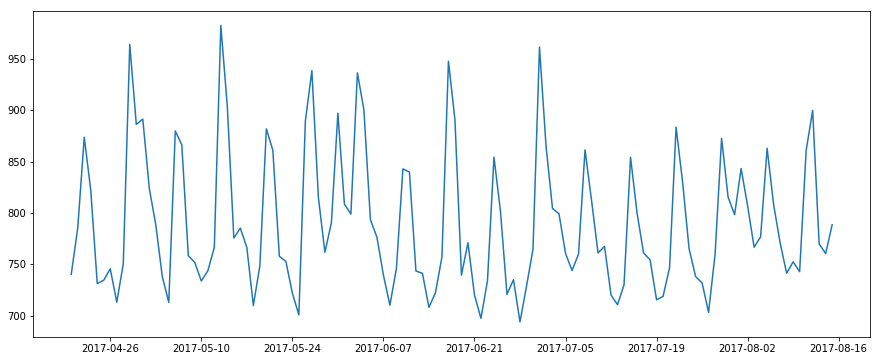

In [325]:
plt.plot(ts.index.to_pydatetime(), ts.values)

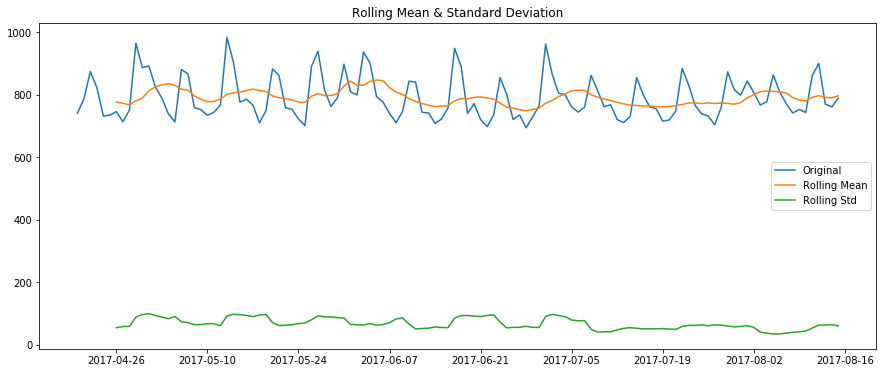

In [326]:
rolmean = ts.rolling(window=7).mean()
rolstd = ts.rolling(window=7).std()

#Plot rolling statistics:
orig = plt.plot(ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [327]:
test = adfuller(ts, autolag='AIC')
print('ADF Statistic: \t\t' + str(test[0]))
print('P Value: \t\t' + str(test[1]))
print('Lags Used: \t\t' + str(test[2]))
print('Observations: \t\t' + str(test[3]))
for key,value in test[4].items():
    print('Critical Value ' + str(key) + ': \t' + str(value))
print('Information Criterion: \t' + str(test[5]))

ADF Statistic: 		-1.88294527852
P Value: 		0.340126229989
Lags Used: 		13
Observations: 		104
Critical Value 1%: 	-3.49485046032
Critical Value 5%: 	-2.88975839867
Critical Value 10%: 	-2.58182201553
Information Criterion: 	1070.48395795


In [328]:
ts_log = np.log(ts)

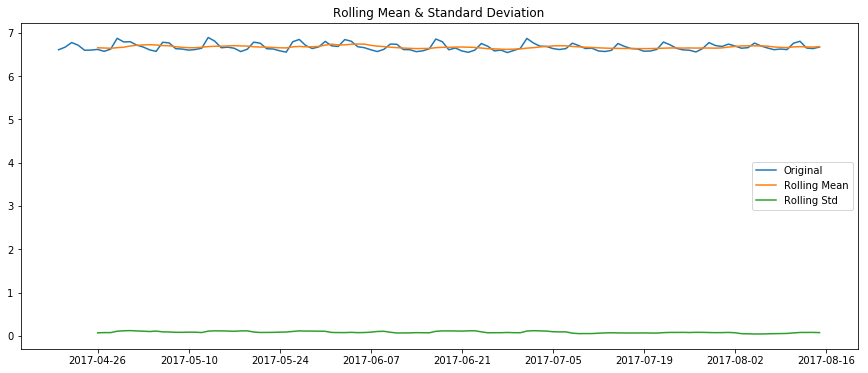

In [329]:
rolmean = ts_log.rolling(window=7).mean()
rolstd = ts_log.rolling(window=7).std()

#Plot rolling statistics:
orig = plt.plot(ts_log, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [330]:
test = adfuller(ts_log, autolag='AIC')
print('ADF Statistic: \t\t' + str(test[0]))
print('P Value: \t\t' + str(test[1]))
print('Lags Used: \t\t' + str(test[2]))
print('Observations: \t\t' + str(test[3]))
for key,value in test[4].items():
    print('Critical Value ' + str(key) + ': \t' + str(value))
print('Information Criterion: \t' + str(test[5]))

ADF Statistic: 		-1.90575484379
P Value: 		0.329358712574
Lags Used: 		13
Observations: 		104
Critical Value 1%: 	-3.49485046032
Critical Value 5%: 	-2.88975839867
Critical Value 10%: 	-2.58182201553
Information Criterion: 	-325.35508179


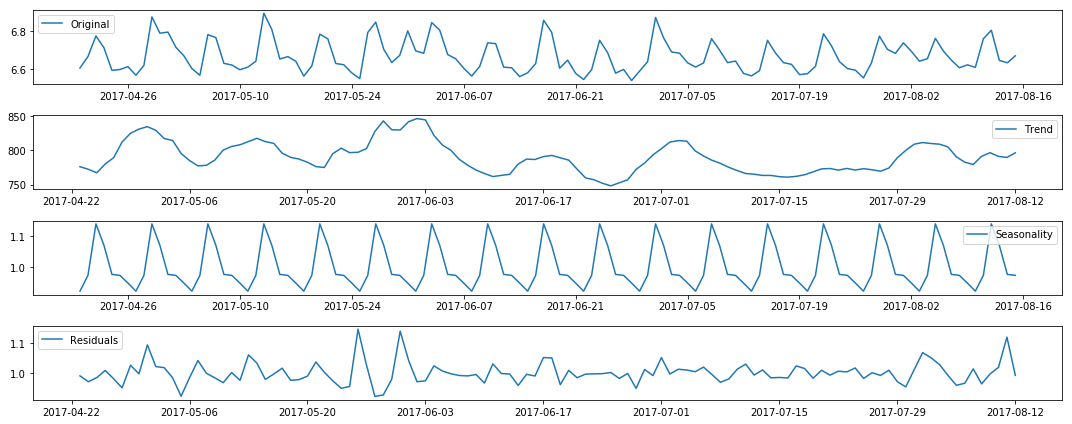

In [331]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts,model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

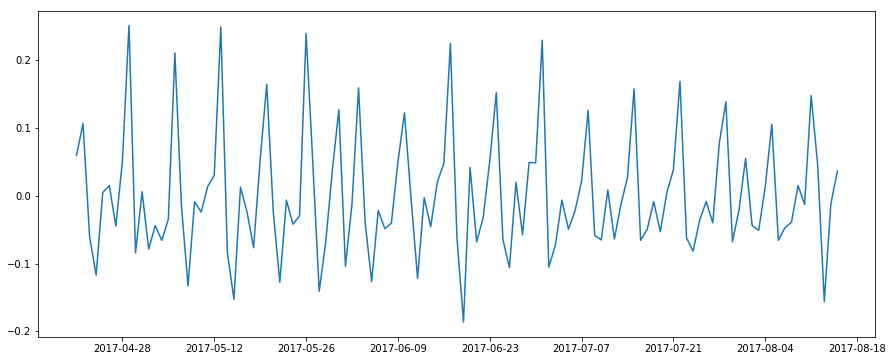

In [332]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff.index.to_pydatetime(), ts_log_diff.values)

In [333]:
ts_log_diff.dropna(inplace=True)

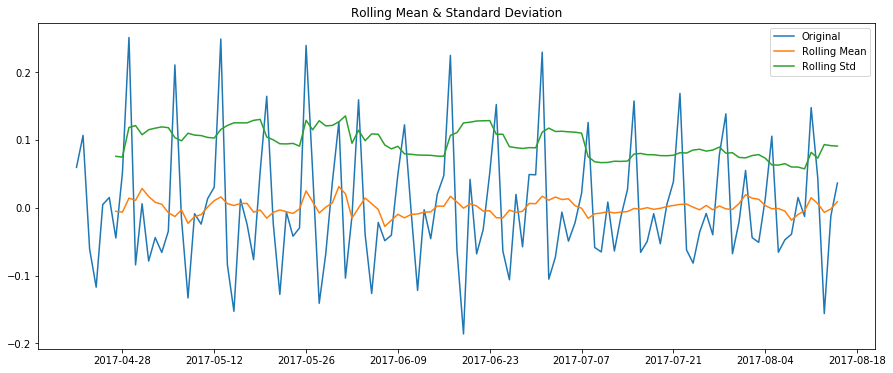

In [334]:
rolmean = ts_log_diff.rolling(window=7).mean()
rolstd = ts_log_diff.rolling(window=7).std()

#Plot rolling statistics:
orig = plt.plot(ts_log_diff, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [335]:
test = adfuller(ts, autolag='AIC')
print('ADF Statistic: \t\t' + str(test[0]))
print('P Value: \t\t' + str(test[1]))
print('Lags Used: \t\t' + str(test[2]))
print('Observations: \t\t' + str(test[3]))
for key,value in test[4].items():
    print('Critical Value ' + str(key) + ': \t' + str(value))
print('Information Criterion: \t' + str(test[5]))

ADF Statistic: 		-1.88294527852
P Value: 		0.340126229989
Lags Used: 		13
Observations: 		104
Critical Value 1%: 	-3.49485046032
Critical Value 5%: 	-2.88975839867
Critical Value 10%: 	-2.58182201553
Information Criterion: 	1070.48395795


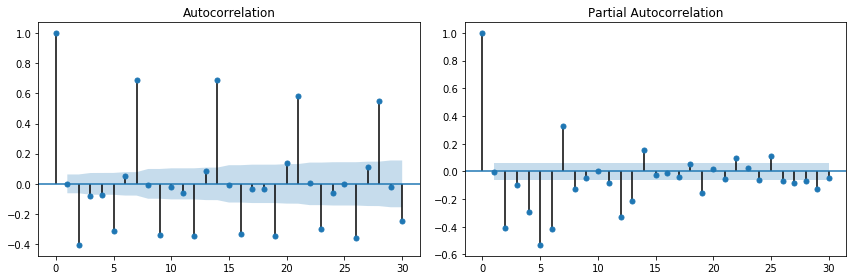

In [336]:
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

In [337]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np

In [338]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [339]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [340]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [341]:
supervised = timeseries_to_supervised(ts_log_diff, 1)
supervised_values = supervised.values

In [342]:
# split into train and test sets
train_size = int(len(supervised_values) * 0.7)
test_size = len(supervised_values) - train_size
train, test = supervised_values[0:train_size,:], supervised_values[train_size:len(supervised_values),:]
print(len(train), len(test))

81 36


In [343]:
scaler, train_scaled, test_scaled = scale(train, test)

In [371]:
#lstm_model = fit_lstm(train_scaled, 1, 1500, 4)
# forecast the entire training dataset to build up state for forecasting
#train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
#trainPred=lstm_model.predict(train_reshaped, batch_size=1)

repeats = 30
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 10, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    
    # walk-forward validation on the test data
    predictions = list(lstm_model.predict(train_reshaped, batch_size=1))
    cumsm=predictions[len(predictions)-1]
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = cumsm+yhat
        cumsm=yhat
        # invert differencing
        yhat = yhat+ts_log[len(train_scaled)+(i-1)]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(ts[1:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

1) Test RMSE: 792.143
2) Test RMSE: 792.699
3) Test RMSE: 792.579
4) Test RMSE: 792.537
5) Test RMSE: 792.419
6) Test RMSE: 792.191
7) Test RMSE: 792.607
8) Test RMSE: 792.257
9) Test RMSE: 792.576
10) Test RMSE: 792.518
11) Test RMSE: 792.449
12) Test RMSE: 792.928
13) Test RMSE: 792.676
14) Test RMSE: 792.467
15) Test RMSE: 792.485
16) Test RMSE: 792.714
17) Test RMSE: 790.987
18) Test RMSE: 792.810
19) Test RMSE: 792.597
20) Test RMSE: 792.630
21) Test RMSE: 792.650
22) Test RMSE: 792.437
23) Test RMSE: 792.714
24) Test RMSE: 792.102
25) Test RMSE: 792.678
26) Test RMSE: 792.679
27) Test RMSE: 792.613
28) Test RMSE: 792.506
29) Test RMSE: 792.468
30) Test RMSE: 792.395


In [345]:
test_reshaped = test_scaled[:, 0].reshape(len(test_scaled), 1, 1)
testPred=lstm_model.predict(test_reshaped, batch_size=1)

In [346]:
train_reshaped=trainPred.tolist()

In [347]:
trainflatten= [y for x in train_reshaped for y in x]

In [348]:
test_reshaped=testPred.tolist()

In [349]:
testflatten= [y for x in test_reshaped for y in x]

In [350]:
predictions=pd.DataFrame(trainflatten)

In [351]:
predictions=predictions.append(testflatten)

In [352]:
predictions['date']=transactions.index[1:]

In [353]:
predictions['date']=pd.to_datetime(predictions['date'], format = '%Y-%m-%d')

In [354]:
predictions=predictions.set_index('date')

In [355]:
predictions_LSTM_diff_cumsum = predictions.cumsum()
predictions_LSTM_log = pd.Series(ts_log.iloc[0], index=ts_log.index)

In [356]:
predictions_LSTM_diff_cumsum=predictions_LSTM_diff_cumsum.T.iloc[0]

In [357]:
predictions_LSTM_log = predictions_LSTM_log.add(predictions_LSTM_diff_cumsum,fill_value=0)

In [358]:
predictions_LSTM = np.exp(predictions_LSTM_log)

Text(0.5,1,'RMSE: 754.5260')

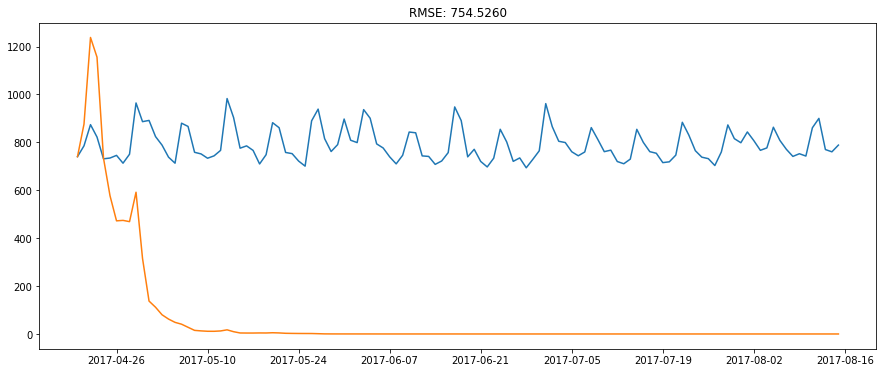

In [359]:
plt.plot(ts.index.to_pydatetime(), ts.values)
plt.plot(ts.index.to_pydatetime(), predictions_LSTM.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_LSTM-ts)**2)/len(ts)))

In [360]:
expected=list(ts)

In [361]:
predictions=predictions.T.iloc[0]

In [362]:
bias=[expected[i]-predictions[i] for i in range(len(predictions))]

In [363]:
mean_forcast_error=sum(bias)/len(bias)
print('Mean forcast error: %f' % mean_forcast_error)

Mean forcast error: 790.524127


In [364]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(expected[1:], predictions)
print('MAE: %f' % mae)

MAE: 790.936520
